In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [5]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# 1. Pre-Processing

In [6]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()
    
    smi_list = list()
    logP_list = list()
    
    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))
        
    logP_list = np.asarray(logP_list).astype(float)
    
    return smi_list, logP_list

def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles)<max_length:
            smiles +=" "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        one_hot = one_hot.astype(float)
        return one_hot
        
    vocab = np.load('./vocab.npy')
    smi_total = []
    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting Data'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

class OneHotLogPDataSet(Dataset):
    def __init__(self, list_one_hot, list_logP):
        self.list_one_hot = list_one_hot
        self.list_logP = list_logP
        
    def __len__(self):
        return len(self.list_one_hot)
    
    def __getitem__(self, index):
        return self.list_one_hot[index], self.list_logP[index]
    
def partition(list_one_hot, list_logP, args):
    num_total = list_one_hot.shape[0]
    num_train = int(num_total*(1-args.test_size-args.val_size))
    num_val = int(num_total*args.val_size)
    num_test = int(num_total*args.test_size)
    
    one_hot_train = list_one_hot[:num_train]
    logP_train = list_logP[:num_train]
    one_hot_val = list_one_hot[num_train:num_train+num_val]
    logP_val = list_logP[num_train:num_train+num_val]
    one_hot_test = list_one_hot[num_total-num_test:]
    logP_test = list_logP[num_total-num_test:]
    
    train_set = OneHotLogPDataSet(one_hot_train, logP_train)
    val_set = OneHotLogPDataSet(one_hot_val, logP_val)
    test_set = OneHotLogPDataSet(one_hot_test, logP_test)
    
    partition = {
        'train' : train_set,
        'val' : val_set,
        'test' : test_set
    }
    
    return partition

In [7]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 50000)
list_one_hot = smiles_to_onehot(list_smi)
dict_partition = partition(list_one_hot, list_logP, args)

KeyboardInterrupt: 

# 2. Model Construction

SkipConnectionBlock can be differed by the number of SkipConnectionLayer, usage of batch normalization, and the number of filter in one layer. A SkipConnectionLayer is composed of 2D convolution layer, which does not change the dimesion of input, batch normalization layer, and ReLU activation layer. A SkipConnectionBlock is composed of n_layer SkipConnectionLayers, skip connection, and ReLU activation layer.

In [1]:
class SkipConnectionLayer(nn.Module):
    
    def __init__(self, in_planes, planes, bn=False):
        super(SkipConnectionLayer, self).__init__()
        
        self.use_bn = bn
        
        self.conv = nn.Conv2d(in_planes,
                              planes,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=False)
        torch.nn.init.xavier_uniform_(self.conv.weight)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        
    def forward(self, x):  
        out = self.conv(x)
        if self.use_bn:
            out = self.bn(out)
        out = self.relu(out)
        return out
    
        
class SkipConnectionBlock(nn.Module):
    
    def __init__(self, n_layer, in_planes, planes, bn=False, sc=True):
        super(SkipConnectionBlock, self).__init__()
        
        self.use_sc = sc
                
        self.list_layer = list()
        for i in range(n_layer):
            self.list_layer.append(SkipConnectionLayer(in_planes if i==0 else planes,
                                                        planes,
                                                        bn))
        self.sc_layers = nn.Sequential(*self.list_layer)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.sc_layers(x)
        if self.use_sc:
            out += residual
        out = self.relu(out)
        
        return out

NameError: name 'nn' is not defined

In [9]:
class BasicConv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    

class InceptionBlock(nn.Module):
    '''(32,120)->(15, 59)'''
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)
        
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
    def forward(self, x):
        branch3x3 = self.branch3x3(x)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3db1_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = self.branch_pool(x)
        
        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [10]:
class Flatten(nn.Module):
    
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [11]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
            
        return out

In [12]:
class SkipConnectionNet(nn.Module):
    
    def __init__(self, args):
        super(SkipConnectionNet, self).__init__()
        
        self.list_block = list()
        for i in range(args.n_block):
            self.list_block.append(SkipConnectionBlock(args.n_layer,
                                                 1 if i==0 else args.n_filter,
                                                 args.n_filter,
                                                 args.bn,
                                                 args.sc))
        self.sc_blocks = nn.Sequential(*self.list_block)
        self.flatten = Flatten()
        pred_shape = self.predictor_shape((args.batch_size, 1, args.n_vocab, args.max_length))
        self.pred1 = Predictor(pred_shape, args.pred_dim1, nn.ReLU())
        self.pred2 = Predictor(args.pred_dim1, args.pred_dim2, nn.ReLU())
        self.pred3 = Predictor(args.pred_dim2, args.out_dim)
        
    def forward(self, x):
        out = self.sc_blocks(x)
        out = self.flatten(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out
        
    def predictor_shape(self, input_shape):       
        dummy_input = torch.zeros(input_shape)
        dummy_output = self.sc_blocks(dummy_input)
        output_shape = dummy_output.shape
        return output_shape[1]*output_shape[2]*output_shape[3]
        

# 3. Train, Validate, and Test

In [13]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
        list_logP = torch.tensor(batch[1]).to(device).float()
        list_logP = list_logP.view(-1,1)
        
        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_one_hot)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_one_hot))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [14]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
            list_logP = torch.tensor(batch[1]).to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_one_hot)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_one_hot))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [15]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
            list_logP = torch.tensor(batch[1]).to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_one_hot)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
        
    return mae, std, logP_total, pred_logP_total

In [16]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = SkipConnectionNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            pin_memory=True,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          pin_memory=True,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           pin_memory=True,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [17]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [18]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    

In [19]:
def plot_loss(df_result, var1, var2):
    def plot(x, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, 1)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', label='Train Loss')
    g.map(plot, 'list_val_loss', color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [20]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiement

In this experiment, hyperparameter tunning will be done to find the best hyperparameter set for the CNN Inception model.

## 5.1 Experiment 1. lr vs n_block

In [49]:
args.batch_size = 100
args.lr = 0.01
args.l2_coef = 0.01
args.optim = 'Adam'
args.epoch = 20
args.n_block = 1
args.n_layer = 2
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.sc = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
list_lr = [0.001, 0.0001, 0.00001, 0.000001]
list_n_block = [1, 2, 3]

dict_result = dict()
n_iter = len(list_lr)*len(list_n_block)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 50000.JSON', orient='table')

lr:0.001/n_block:1
lr:0.001/n_block:2
lr:0.001/n_block:3
lr:0.0001/n_block:1
lr:0.0001/n_block:2
lr:0.0001/n_block:3
lr:1e-05/n_block:1
lr:1e-05/n_block:2
lr:1e-06/n_block:1
lr:1e-06/n_block:2
lr:1e-06/n_block:3



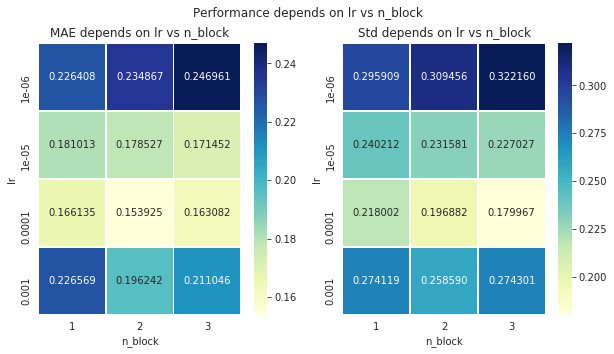

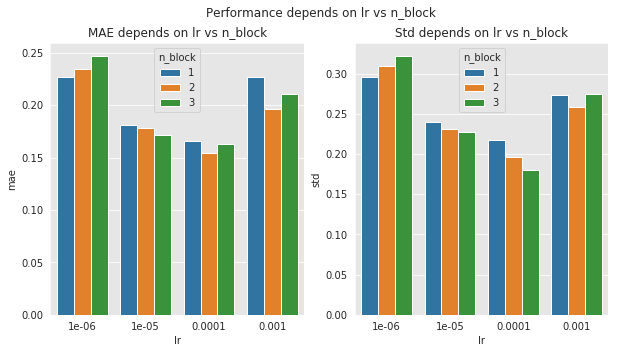

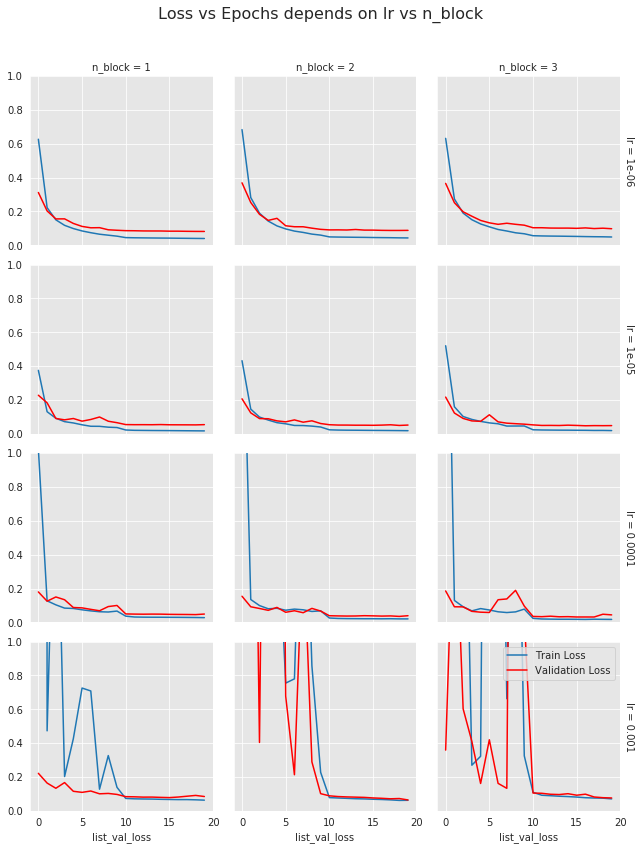

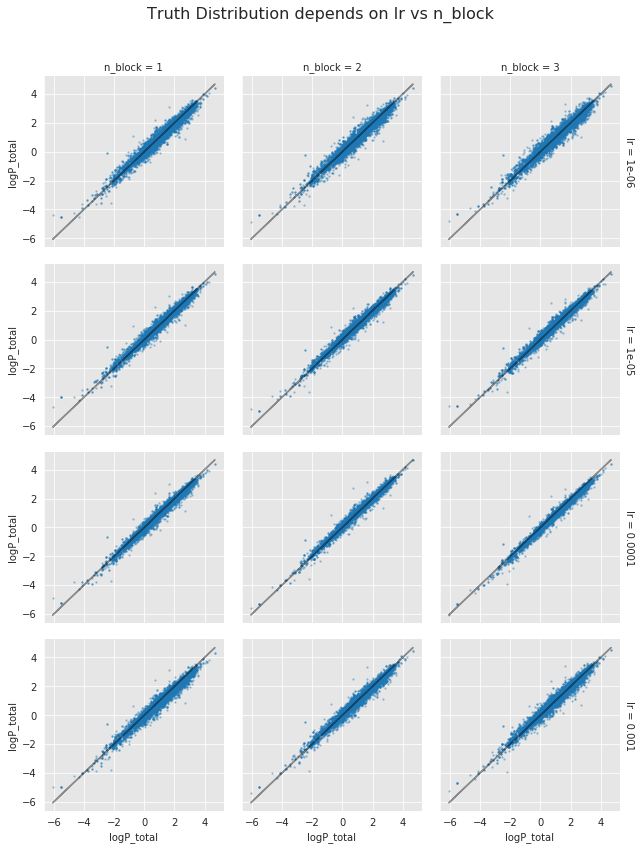

In [46]:
df_result = pd.read_json('lr vs n_block 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 1. lr vs n_block
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __learning rate (lr)__ and __number of Skip Connection Block (n_block)__ used in the each model.

The learning rate was chose to be the first hyperparameters to be tuned because if we find the best learning rate, no matter what the model architecture is, we can use that learning rate to future exepriemnts. Thus, the number of block, which effetcs the model architecture the most, was chose to be the second.
#### Variable Domain
- __lr__ : [0.001, 0.0001, 0.00001, 0.000001]
- __n_block__ : [1, 2, 3]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.
#### Notable Results
- No matter what number of Skip Connection Block is, both MAE and std value were the lowest if learning rate of 0.00001
- The performance does not show a notable tendency with respect to the number of Skip Connection Block.
- There were no overfitting for every cases, but the loss graph with learning rate of 0.01 was unstable.

#### Discussion
- The performance was best at learning rate of 0.00001 for every number of Skip Connection Block. Thus 0.00001 is the best learning rate for my models.
- The performance does not show a notable tendency with respect to the number of Skip Connection Block. However, around the best learning rate (exclude the learning rate of 0.01 since the result is not plausible due to the unstableness of loss change) the performance increased as the number of Skip Connection Block increases. It might suggest that more blocks gives better output, but not quite sure due to the lack of data. I tried to conduct expermients with 4 blocks to confirm the hypothesis, but failed beacause of the lack of memory.
- The experiment result is palusible since validation loss  was always larger than the train loss. Also the gap between two loss was small. 
- No overfitting occured. I think this is because of the large l2_coefficient.
- After epoch of 10, the model does not learn anymore. Thus I tried the learning rate scheduler. It improved the performance slightly.

After this experiment, the learning rate and the number of blocks were fixed to 0.00001 and 2. Models with three blocks might perform better than models with two blocks, but training took so much time for the models with three blocks.

## 5.2 Experiement 2. n_layer vs sc

In [22]:
args.batch_size = 100
args.lr = 0.0001
args.l2_coef = 0.01
args.optim = 'Adam'
args.epoch = 20
args.n_block = 2
args.n_layer = 2
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.sc = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
list_n_layer = [1,2,3,4]
list_sc = [True, False]
var1 = "n_layer"
var2 = "sc"

dict_result = dict()
n_iter = len(list_n_layer)*len(list_sc)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for sc in list_sc:
        args.n_layer = n_layer
        args.sc = sc
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(sc)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs sc 50000.JSON', orient='table')

AttributeError: 'Namespace' object has no attribute 'epoch'

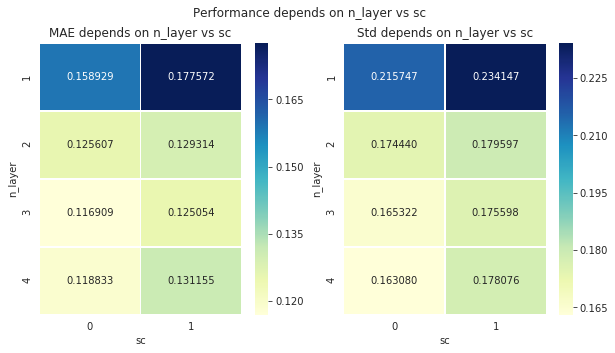

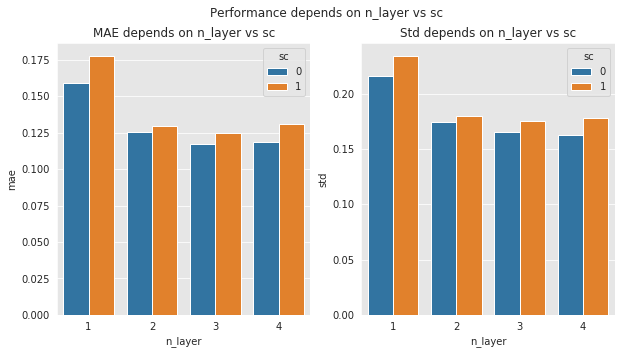

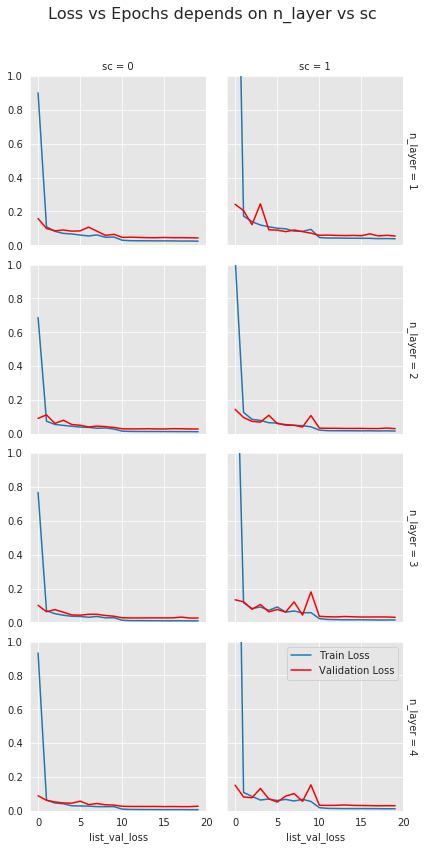

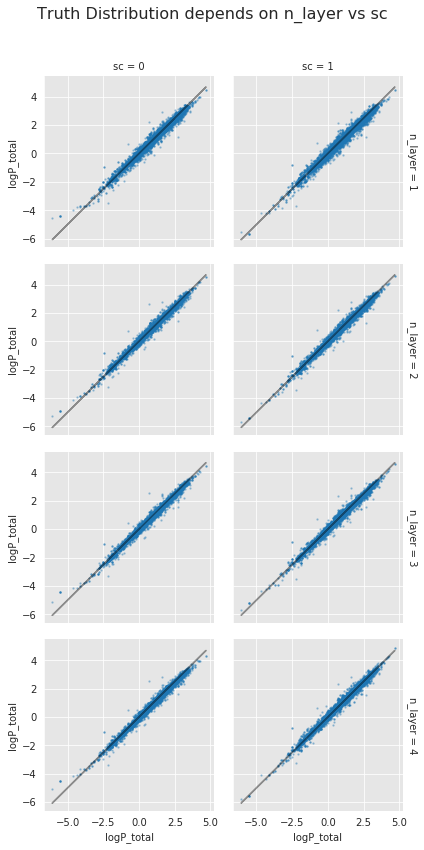

In [24]:
df_result = pd.read_json('n_layer vs sc 50000.JSON', orient='table')
var1 = "n_layer"
var2 = "sc"

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 2. n_layer vs sc
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __number of layers in each block (n_layer)__ and __usage of skip connection (sc)__ for each model.

#### Variable Domain
- __n_layer__ : [1, 2, 3, 4]
- __sc__ : [True, False]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- As the number of layer increases, the performance increased.
- For every cases, models without skip connection showed better results than models with skip connection. 
- There were no overfitting for every cases.
- At epoch of 10, the loss graph breaks slightly and the unstableness of the loss graph vanishes.

#### Discussion
- As expected, performance increased as the number of layer increases. As model become deeper, model become able to learn more difficult problems. 
- However, there were no big difference of performance between the models with three and four layers. It might suggest that three layers per block is enough for the logP prediction problem.
- Not as expected, model without skip connection showed better performance than model with skip connection for every cases. In addition, the loss degradation was slow and unstable for the model with skip connection. I think too much gradient was given to the shallow part of the model by the skip connection, thus the model did not learn properly but slow and unstable. This hypothesis agrees with the vanish of unstableness after the epoch of 10, where step down of learning rate take place: as the learning rate step down, the effect of gradient decreases. It might be solved with gated skip connection, decreasing the effect of skip connection to the gradient descent, or with finding proper initial learning rate. 
- The experiment result is palusible since validation loss  was always larger than the train loss. Also the gap between two loss was small. 
- No overfitting occured. I think this is because of the large l2_coefficient.
- After epoch of 10, the model does not learn anymore. Thus I tried the learning rate scheduler. It improved the performance slightly, but still the model does not learn after certain epoch. Increasing the value of gamma might solve the problem.
- In this experiement, we can see the effect of the learning rate scheduler, by the break of loss graph at epoch of 10.

After this experiment, the number of layer was fixed to 3, since it showed the best result. The usage of skip connection was fixted to True even it showed worse result, since this assignment is about the skip connection.

## 5.3 Experiemnt 3. n_filter vs bn

In [25]:
args.batch_size = 100
args.lr = 0.0001
args.l2_coef = 0.01
args.optim = 'Adam'
args.epoch = 20
args.n_block = 2
args.n_layer = 3
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.sc = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
list_n_filter = [32, 64, 128]
list_bn = [True, False]
var1 = "n_filter"
var2 = "bn"

dict_result = dict()
n_iter = len(list_n_filter)*len(list_bn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_filter in list_n_filter:
    for bn in list_bn:
        args.n_filter = n_filter
        args.bn = bn
        args.exp_name = var1+':'+str(n_filter)+'/'+var2+':'+str(bn)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_filter vs bn 50000.JSON', orient='table')

n_filter:32/bn:True
n_filter:32/bn:False
n_filter:64/bn:True
n_filter:64/bn:False
n_filter:128/bn:True
n_filter:128/bn:False


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



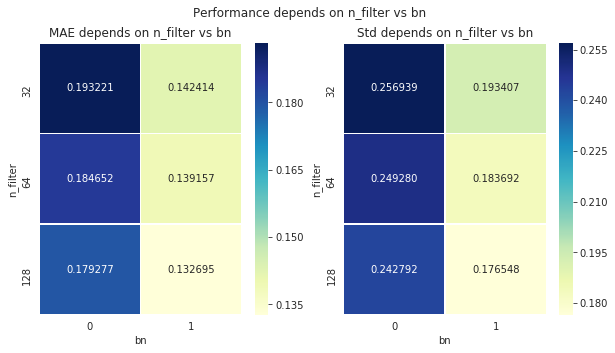

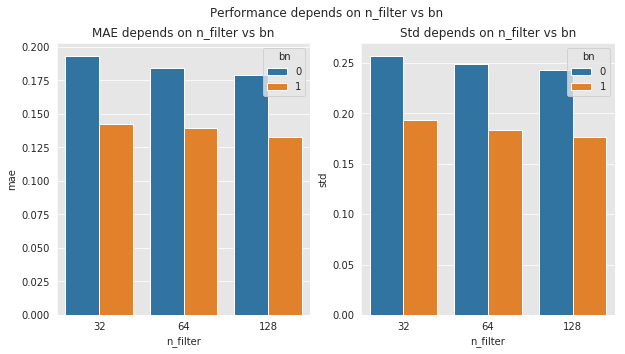

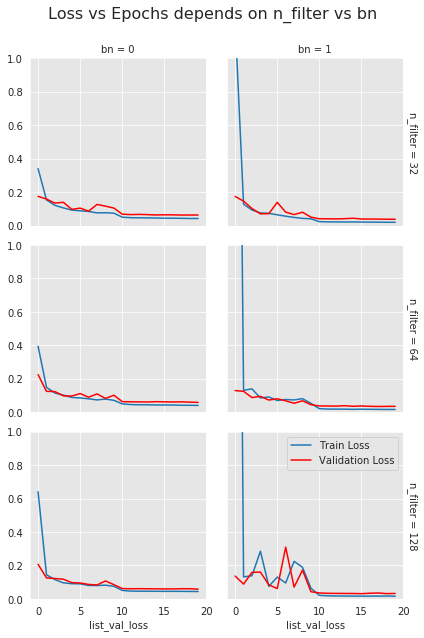

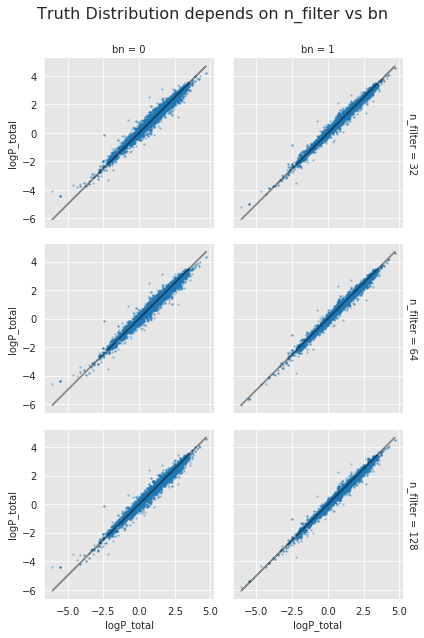

In [30]:
df_result = pd.read_json('n_filter vs bn 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 3. n_filter vs bn
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __number of fiters in each convolution layer (n_filter)__ and __usage of batch normalization (bn)__ for each model.

#### Variable Domain
- __n_filter__ : [32, 64, 128]
- __bn__ : [True, False]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- As the number of filter increases, the performance increased slightly.
- For every cases, models with batch normalization showed better results than models without batch normalization.
- There were no overfitting for every cases.
- At epoch of 10, the loss graph bends slightly and the unstableness of loss graph vanishes.

#### Discussion
- As expected, performance increased as the number of filters increases. As the model capacity increases, model become able to learn more difficult problems. However, the perforamance increase was not that dramatic as expected.
- Batch normalization showed remarkable performance increase for every cases. I think this is because of ReLU activations I've used in the model. As batch normalization cancles the negative bias, it prevents the "dead ReLU" problem. 

After this experiment, the number of filters was fixed to 128, since it showed the best result. The usage of batch normalization was fixted to True.

## 5.4 Experiment 4. pred_dim1 vs pred_dim2

In [20]:
args.batch_size = 100
args.lr = 0.0001
args.l2_coef = 0.01
args.optim = 'Adam'
args.epoch = 20
args.n_block = 2
args.n_layer = 3
args.n_filter = 128
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.sc = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
list_pred_dim1 = [64, 128, 256]
list_pred_dim2 = [16, 32, 64]
var1 = "pred_dim1"
var2 = "pred_dim2"

dict_result = dict()
n_iter = len(list_pred_dim1)*len(list_pred_dim2)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim1 in list_pred_dim1:
    for pred_dim2 in list_pred_dim2:
        args.pred_dim1 = pred_dim1
        args.pred_dim2 = pred_dim2
        args.exp_name = var1+':'+str(pred_dim1)+'/'+var2+':'+str(pred_dim2)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim1 vs pred_dim2 50000.JSON', orient='table')

pred_dim1:64/pred_dim2:16
pred_dim1:64/pred_dim2:32
pred_dim1:64/pred_dim2:64
pred_dim1:128/pred_dim2:16
pred_dim1:128/pred_dim2:32
pred_dim1:128/pred_dim2:64
pred_dim1:256/pred_dim2:16
pred_dim1:256/pred_dim2:32
pred_dim1:256/pred_dim2:64



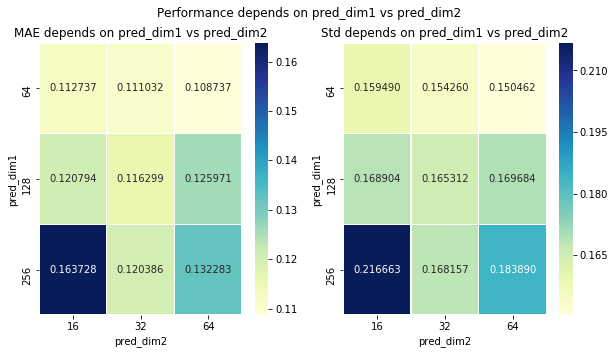

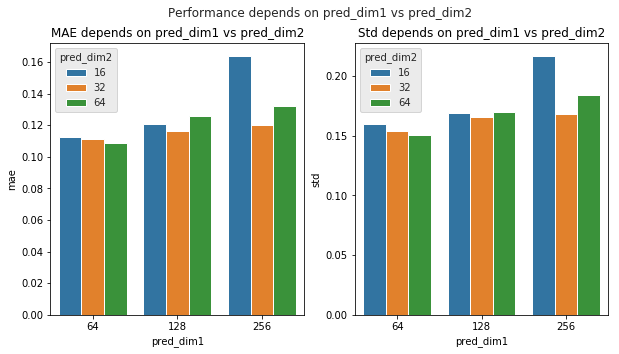

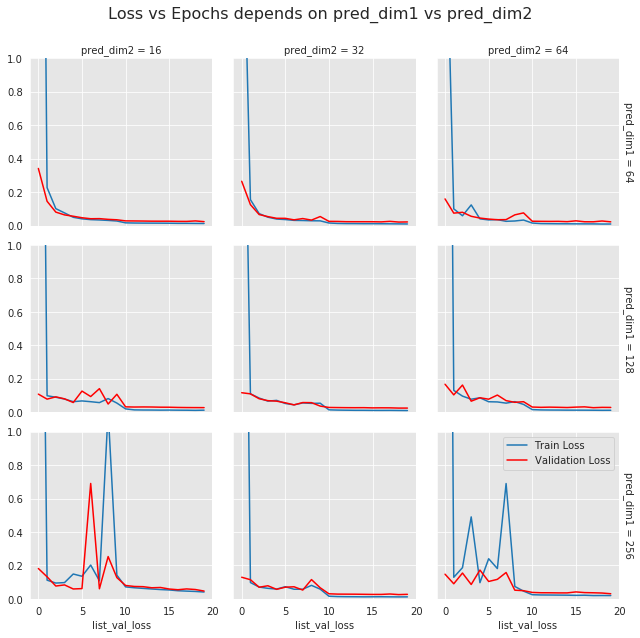

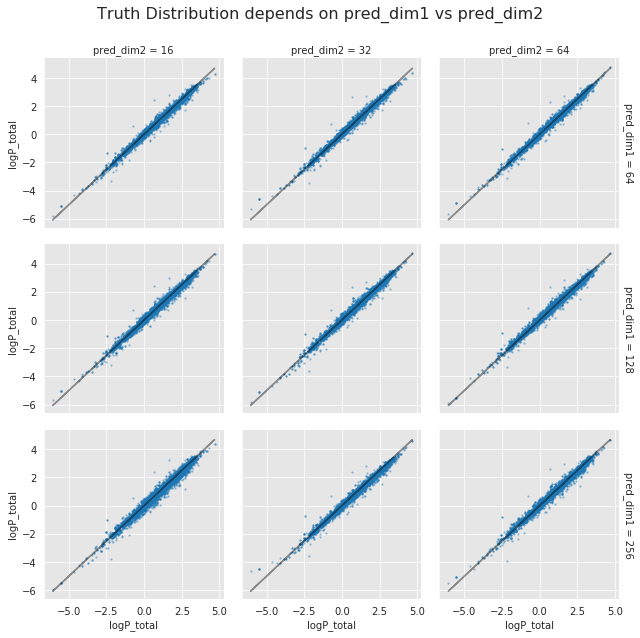

In [22]:
df_result = pd.read_json('pred_dim1 vs pred_dim2 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 4. pred_dim1 vs pred_dim2
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __dimension of the first predictor layer (pred_dim1)__ and __dimension of the second predictor layer (pred_dim2)__ for each model.

#### Variable Domain
- __pred_dim1__ : [64, 128, 256]
- __pred_dim2__ : [16, 32, 64]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- (64, 64) showed the best result and (256, 16) showed the worst.
- The smaller dimension of first predictor layer showed better result.
- There were no overfitting for every cases.
- At epoch of 10, the loss graph bends slightly and the unstableness of loss graph vanishes.

#### Discussion
- There was no notable tendency between the performance and the dimesion of predicting layers. However, it was quite surprising that (64, 64) showed the best result because usually the preceding predicting layer's dimesion is larger than the succeeding one's. 

After this experiment, the dimesion of both predicting layer were fixed to 64 as it showed the best result.

# 6. Summary

- I've expected that there will be a best learning rate that fits to every models. Thus I performed the experiment determining the best learning rate first. However, this learning rate was not the best for every model I've used. This turns out the unstableness of the loss degradation. Finding the best learning rate for each model would solve this problem, but it will take a huge amount of time.
- Step down learning rate scheduler solved the aformentioned problem by different learning rates in one training.
- Unfortunately, the skip connection hindered the performance of the model. Gated skip conneciton of GCN or proper learning rate setting might solve the problem.
- CNN models take too much time for training.
- Prediction of logP was inaccurate for the positive and negative end of logP for every cases. I think this is due to the lack of data at those parts. 

# 7. Best performance

In this expermient, a model with tunned hyperparamter set will be trained by 190000 data with 50 epochs to get the best performance with CNN model.

In [31]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 190000)
list_one_hot = smiles_to_onehot(list_smi)
dict_partition = partition(list_one_hot, list_logP, args)

In [32]:
args.batch_size = 100
args.lr = 0.0001
args.l2_coef = 0.01
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2
args.n_layer = 3
args.n_filter = 128
args.pred_dim1 = 64
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.sc = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

MAE: 0.0563159197
Std: 0.0887518303


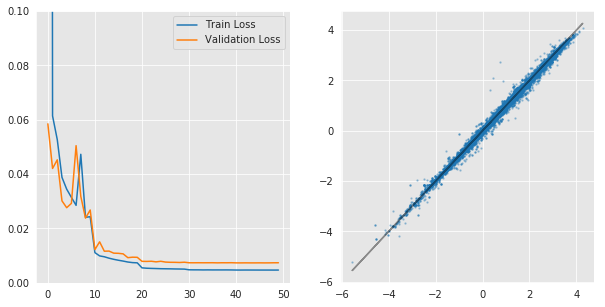

In [25]:
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 0.1])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)